#### Example 1 :  Simple RAG with Retriever and chains

How rag works : https://python.langchain.com/docs/tutorials/rag/

Architecture workflow :

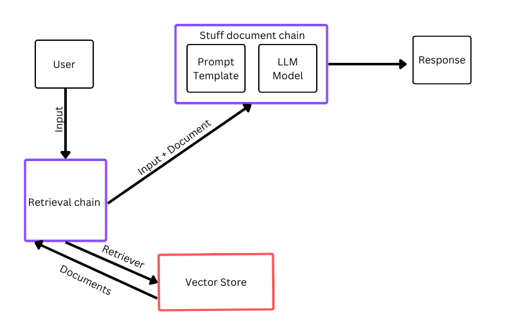

In [48]:
import os
from dotenv import load_dotenv
import langchain
from langchain.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain
from langchain_groq import ChatGroq
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
load_dotenv()

True

In [49]:
# loading the env variables require
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [50]:
# creating the prompt template
prompt_template = ChatPromptTemplate.from_template(
    """You are a generative ai expert, who has good knowledge of data science. Answer the following question 
    based on the provided {context}.If you don't know the answer, just say that you don't know, don't try to 
    make up an answer.
    <context>
    {context}
    </context>
    
    Question : {input}
    """
)

In [51]:
# loading the llm model using groq
model_id = "llama-3.3-70b-versatile"
model = ChatGroq(
    model=model_id,
    temperature=0.5,
    max_retries=2,
)

create_stuff_document_chain --> Create a chain for passing a list of Documents to a model.

In [52]:
# creating the stuff document chain
stuff_chain = create_stuff_documents_chain(llm=model,prompt=prompt_template)

In [53]:
# loading the document
loader = PyPDFLoader(file_path="attention_all_you_need.pdf")
docs = loader.load()

In [54]:
# transforming the document by splitting it
splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
douments =splitter.split_documents(docs)

In [55]:
# embeddings model
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}
hf = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

In [ ]:
# store the data into vectorstore chroma
chroma_db = Chroma('chroma_vectorstore',embedding_function=hf)
chroma_db.add_documents(documents=douments)

In [57]:
# query some documents using similarity search (testing purpose)
query = "What is multihead attention ?"
retrieve_docs = chroma_db.similarity_search(query,k=5)

Retriever class returns Documents given a text query.

It is more general than a vector store. A retriever does not need to be able to store documents, only to return (or retrieve) it. Vector stores can be used as the backbone of a retriever, but there are other types of retrievers as well.

In [58]:
# create the retriever, who retrieve the similar data from the vectorstore
retriever = chroma_db.as_retriever(
    search_type="similarity",
    search_kwargs={'k': 5}
)

In [59]:
# create a retrieval chain that passes the document further
retrieval_chain = create_retrieval_chain(retriever=retriever,combine_docs_chain=stuff_chain)

In [64]:
# getting the response from the retrieval_chain
query = "What is multihead attention ?"
response = retrieval_chain.invoke({'input':query})

In [65]:
response

{'input': 'What is multihead attention ?',
 'context': [Document(metadata={'page': 3, 'source': 'attention_all_you_need.pdf'}, page_content='we found it beneﬁcial to linearly project the queries, keys and values htimes with different, learned\nlinear projections to dk,dkanddvdimensions, respectively. On each of these projected versions of\nqueries, keys and values we then perform the attention function in parallel, yielding dv-dimensional\noutput values. These are concatenated and once again projected, resulting in the ﬁnal values, as\ndepicted in Figure 2.\nMulti-head attention allows the model to jointly attend to information from different representation\nsubspaces at different positions. With a single attention head, averaging inhibits this.\n4To illustrate why the dot products get large, assume that the components of qandkare independent random\nvariables with mean 0and variance 1. Then their dot product, q·k=∑dk\ni=1qiki, has mean 0and variance dk.\n4'),
  Document(metadata={'pag

#### Example 2 : RAG + Retriever different approach

In [3]:
# loading the env variables require
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

In [5]:
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_groq import ChatGroq
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

#### INDEXING ####

# Load Documents
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

##1 - 0 - 1000 , 800 - 1800

# Split - Chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
hf_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs
)
vectorstore = FAISS.from_documents(documents=splits, embedding=hf_embeddings)

retriever = vectorstore.as_retriever() # Dense Retrieval - Embeddings/Context based

#### RETRIEVAL and GENERATION ####

# Prompt
prompt = hub.pull("rlm/rag-prompt")
print(prompt)

# LLM
llm = ChatGroq(model="llama3-8b-8192", temperature=0)

# Post-processing the context
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    # we can format documents as per usecase and its experimental to get a better response.
    # RunnablePassthrough() allows us to pass the question at runtime
    | prompt
    | llm
    | StrOutputParser()
)

# Question
print(rag_chain.invoke("What is Task Decomposition?"))

c:\Users\admin\anaconda3\envs\env_langchain_tutorial\lib\site-packages\langsmith\client.py:256: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]
Task Decomposition is a process that breaks down a complicated task into smaller and simpler steps, allowing an agent to plan ahead and utilize more test-time computation. This is achieved through techniques such as Chain of Thought (CoT) and Tree of Thoughts (Yao et al. 2023), which transform big tasks in

In [11]:
print(prompt.messages[0].prompt.template)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [16]:
docs = retriever.get_relevant_documents("What is task decomposition ?")
context = ""
for doc in docs:
    context += doc.page_content
print(context)

Fig. 1. Overview of a LLM-powered autonomous agent system.
Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what they are and plan ahead.
Task Decomposition#
Chain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majority vote.
Ta